In [1]:
"""Train a simple CNN-Capsule Network on the CIFAR10 small images dataset.

Without Data Augmentation:
It gets to 75% validation accuracy in 10 epochs,
and 79% after 15 epochs, and overfitting after 20 epochs

With Data Augmentation:
It gets to 75% validation accuracy in 10 epochs,
and 79% after 15 epochs, and 83% after 30 epcohs.
In my test, highest validation accuracy is 83.79% after 50 epcohs.

This is a fast Implement, just 20s/epcoh with a gtx 1070 gpu.
"""

from __future__ import print_function

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule import capsulelayers
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [4]:
n = 10
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, 
    n_polyrythms=1,
    n_channels=3,
    multiTrack=multiTrack)

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666656
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0645833333333328
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9916666666666658
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0208333333333326
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9968749999999997
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9916666666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0208333333333335
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.022916666666666
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0260416666666665
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (10, 100, 3)


In [5]:
n = 10
total = 1000 * 1
x_test = x_train[n:]
x_train = np.concatenate([x_train[:n] for _ in range(int(total/n))])

In [6]:
x_train = x_train.reshape(list(x_train.shape) + [1])
x_test = x_train[:-500]

In [7]:
x_train.shape

(1000, 100, 3, 1)

In [8]:
y_train = np.concatenate([list(range(n)) for _ in range(int(total/n)+1)])[:total]
y_train = keras.utils.to_categorical(y_train)
y_test = y_train[-500:]
y_train.shape

(1000, 10)

In [9]:
num_classes = 10
m = 9000

In [10]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train[:m].astype('float32')
# x_test = x_test[:1000].astype('float32')
# y_train = y_train[:m]
# y_test = y_train[:1000]
# x_train /= 255
# x_test /= 255
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
x_train.shape

(1000, 100, 3, 1)

In [12]:
y_train.shape

(1000, 10)

m (30, 3)


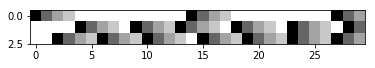

In [13]:
# plt.imshow(x_train[0,:,:,0])
plot.multi(x_train[0,:30,:,0])

In [14]:
# A common Conv2D model
n_channels = x_train.shape[-1]
n_notes = x_train.shape[-2]
kernel_size = (3,3) if n_notes > 27 else (3,1)

input_image = Input(shape=(None, None, n_channels))
x = input_image
# print(K.int_shape(x))
x = Reshape((-1, 1))(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Conv1D(64, 3, activation='relu')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Reshape((-1, 1,1))(x)


# x = Reshape(x_train.shape[:-1])(x)
# x = Conv2D(64, (3,3), activation='relu')(input_image)
# x = Conv2D(64, kernel_size, activation='relu')(x)
# x = AveragePooling2D((2, 2))(x)
# x = Conv2D(128, kernel_size, activation='relu')(x)
# x = Conv2D(128, kernel_size, activation='relu')(x)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(10, 16, 3, True)(x)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
output = capsulelayers.Length(name='capsnet')(capsule)
# output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

model = Model(inputs=input_image, outputs=output)

NameError: name 'Capsule' is not defined

In [ ]:
# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

In [15]:
phase_mod = 0.
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [39]:
batch_size = 128
epochs = 15

In [40]:
# we can compare the performance with or without data augmentation
data_augmentation = False
data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        workers=4)


Using real-time data augmentation.
Epoch 1/15
8/8 [==============================] - 5s 633ms/step - loss: 0.5774 - acc: 0.1457 - val_loss: 0.5012 - val_acc: 0.2000
Epoch 2/15
8/8 [==============================] - 4s 524ms/step - loss: 0.4822 - acc: 0.3343 - val_loss: 0.4614 - val_acc: 0.3000
Epoch 3/15
8/8 [==============================] - 4s 494ms/step - loss: 0.4491 - acc: 0.3009 - val_loss: 0.4311 - val_acc: 0.4000
Epoch 4/15
8/8 [==============================] - 4s 458ms/step - loss: 0.4177 - acc: 0.4349 - val_loss: 0.3952 - val_acc: 0.5000
Epoch 5/15
8/8 [==============================] - 4s 458ms/step - loss: 0.3837 - acc: 0.5695 - val_loss: 0.3617 - val_acc: 0.6000
Epoch 6/15
8/8 [==============================] - 4s 460ms/step - loss: 0.3514 - acc: 0.6569 - val_loss: 0.3311 - val_acc: 0.6000
Epoch 7/15
8/8 [==============================] - 4s 487ms/step - loss: 0.3185 - acc: 0.7510 - val_loss: 0.2942 - val_acc: 0.7000
Epoch 8/15
8/8 [==============================] - 4s 48

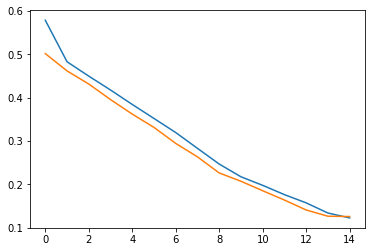

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

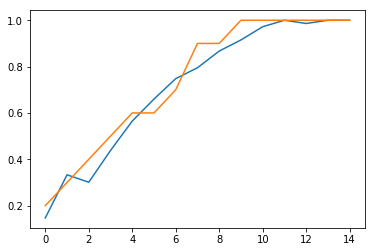

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

m (30, 3)


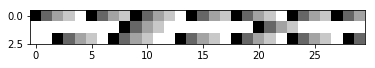

m (30, 3)


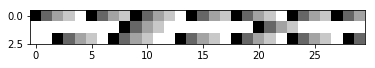

In [23]:
i = 1
x = datagen.random_transform(x_train[i])
plot.multi(x[:30,:,0])
plot.multi(x_train[i,:30,:,0])

m (30, 3)


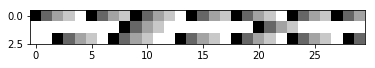

m (30, 3)


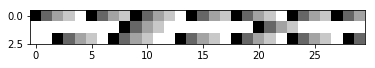

In [24]:
i = 1
x = datagen.standardize(x_train[i:i+batch_size])
x.shape
x = x[0]
plot.multi(x[:30,:,0])
plot.multi(x_train[i,:30,:,0])

In [25]:
# plt.imshow(x[:,:,0])

In [26]:
# plt.imshow(x_train[i,:,:,0])